## Analysis of FF Invasive Ductal Carcinoma Breast Tissue with scanpy then identification of SVGs with SpatialDE

In [10]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import seaborn as sns
import squidpy as sq
import csv
from sklearn.metrics.pairwise import cosine_distances

In [11]:
#load in dataset
ff_human_breast_cancer = sc.datasets.visium_sge('V1_Breast_Cancer_Block_A_Section_1')
ff_human_breast_cancer.var_names_make_unique()

/Users/nataliecharitakis/opt/anaconda3/envs/squidpy/lib/python3.10/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [12]:
#Calculate some QC metrics for the data
ff_human_breast_cancer.var["mt"] = ff_human_breast_cancer.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(ff_human_breast_cancer, qc_vars=["mt"], inplace=True)

<IPython.core.display.Javascript object>


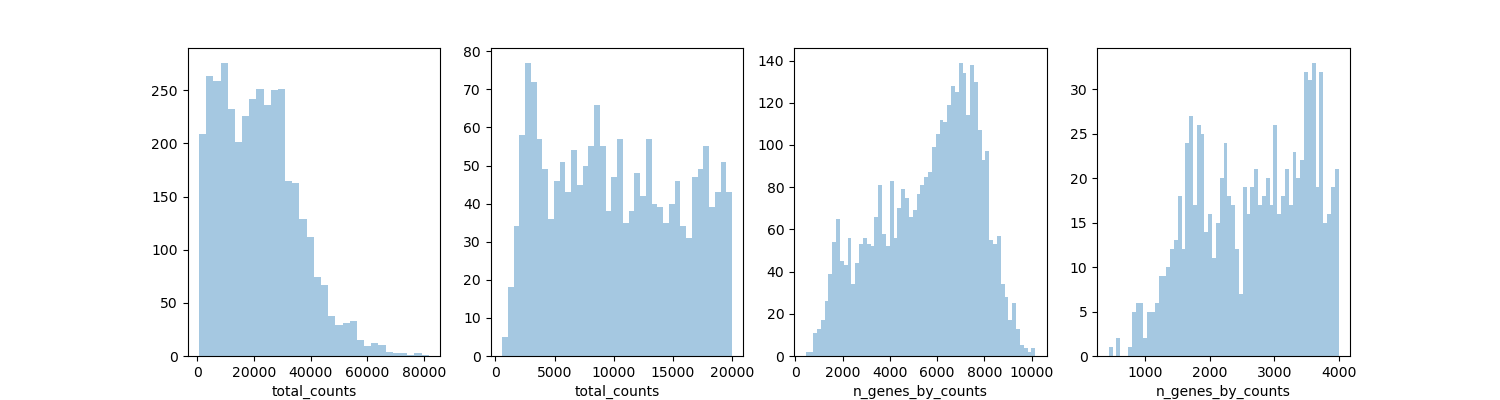

/var/folders/z2/blpwq8wx3p37k5lbxzs9vyf80000gn/T/ipykernel_61921/3946142589.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ff_human_breast_cancer.obs["total_counts"], kde=False, ax=axs[0])
/var/folders/z2/blpwq8wx3p37k5lbxzs9vyf80000gn/T/ipykernel_61921/3946142589.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad63727

<IPython.core.display.Javascript object>


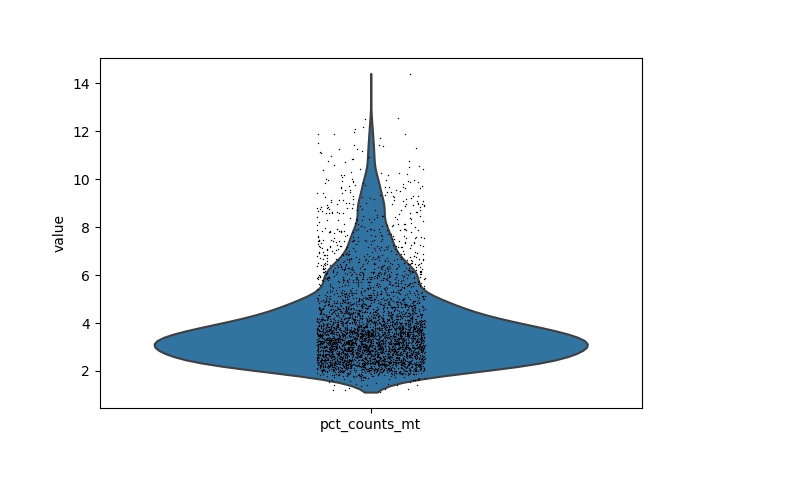

In [13]:
#Visualise some QC metrics for the data
%matplotlib notebook

fig, axs = plt.subplots(1, 4, figsize=(15, 4))
sns.distplot(ff_human_breast_cancer.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(ff_human_breast_cancer.obs["total_counts"][ff_human_breast_cancer.obs["total_counts"] < 20000], kde=False, bins=40, ax=axs[1])
sns.distplot(ff_human_breast_cancer.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[2])
sns.distplot(ff_human_breast_cancer.obs["n_genes_by_counts"][ff_human_breast_cancer.obs["n_genes_by_counts"] < 4000], kde=False, bins=60, ax=axs[3])
sc.pl.violin(ff_human_breast_cancer,['pct_counts_mt'])

In [14]:
ff_human_breast_cancer

AnnData object with n_obs × n_vars = 3798 × 36601
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'spatial'
    obsm: 'spatial'

In [15]:
#Perform some filtering
sc.pp.filter_cells(ff_human_breast_cancer, min_counts=5000)
print(f'Number of cells after min count filter: {ff_human_breast_cancer.n_obs}')
sc.pp.filter_cells(ff_human_breast_cancer, max_counts=60000)
print(f'Number of cells after max count filter: {ff_human_breast_cancer.n_obs}')
ff_human_breast_cancer = ff_human_breast_cancer[ff_human_breast_cancer.obs["pct_counts_mt"] < 10]
ff_human_breast_cancer = ff_human_breast_cancer[ff_human_breast_cancer.obs["pct_counts_mt"] > 2]
print(f"#cells after MT filter: {ff_human_breast_cancer.n_obs}")
#Filter out genes that are detected in less than 10 cells
sc.pp.filter_genes(ff_human_breast_cancer, min_cells=10)
print(f'Number of genes after cell filter: {ff_human_breast_cancer.n_vars}')
sc.pp.filter_cells(ff_human_breast_cancer, min_genes = 3000)
print(f'Number of cells after gene filter: {ff_human_breast_cancer.n_obs}')

Number of cells after min count filter: 3388
Number of cells after max count filter: 3347
#cells after MT filter: 3172


/Users/nataliecharitakis/opt/anaconda3/envs/squidpy/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:251: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['n_cells'] = number


Number of genes after cell filter: 19456
Number of cells after gene filter: 3030


In [16]:
##Do normalisation and find highly variable genes
sc.pp.normalize_total(ff_human_breast_cancer, inplace=True)
sc.pp.log1p(ff_human_breast_cancer)
sc.pp.highly_variable_genes(ff_human_breast_cancer, flavor="seurat", n_top_genes=2000)

<IPython.core.display.Javascript object>


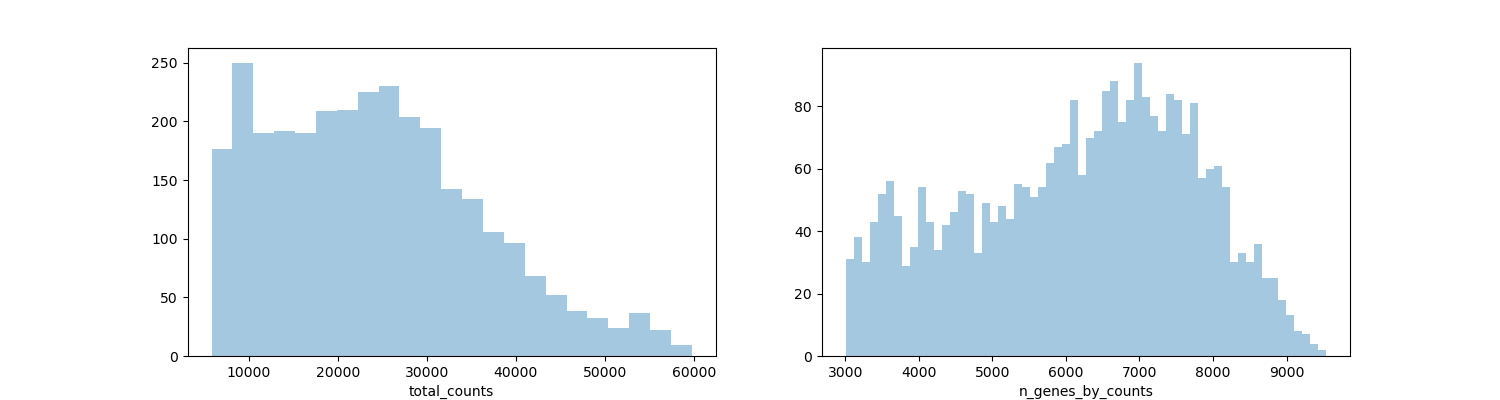

/var/folders/z2/blpwq8wx3p37k5lbxzs9vyf80000gn/T/ipykernel_61921/2235892410.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(ff_human_breast_cancer.obs["total_counts"], kde=False, ax=axs[0])
/var/folders/z2/blpwq8wx3p37k5lbxzs9vyf80000gn/T/ipykernel_61921/2235892410.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad63727

<AxesSubplot: xlabel='n_genes_by_counts'>

In [17]:
#Look at distribution after normalisation
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
sns.distplot(ff_human_breast_cancer.obs["total_counts"], kde=False, ax=axs[0])
sns.distplot(ff_human_breast_cancer.obs["n_genes_by_counts"], kde=False, bins=60, ax=axs[1])

In [18]:
#Perform next steps in cluster identification
sc.pp.pca(ff_human_breast_cancer,n_comps=20)
sc.pp.neighbors(ff_human_breast_cancer)
sc.tl.umap(ff_human_breast_cancer)
sc.tl.leiden(ff_human_breast_cancer, key_added='clusters')

<IPython.core.display.Javascript object>


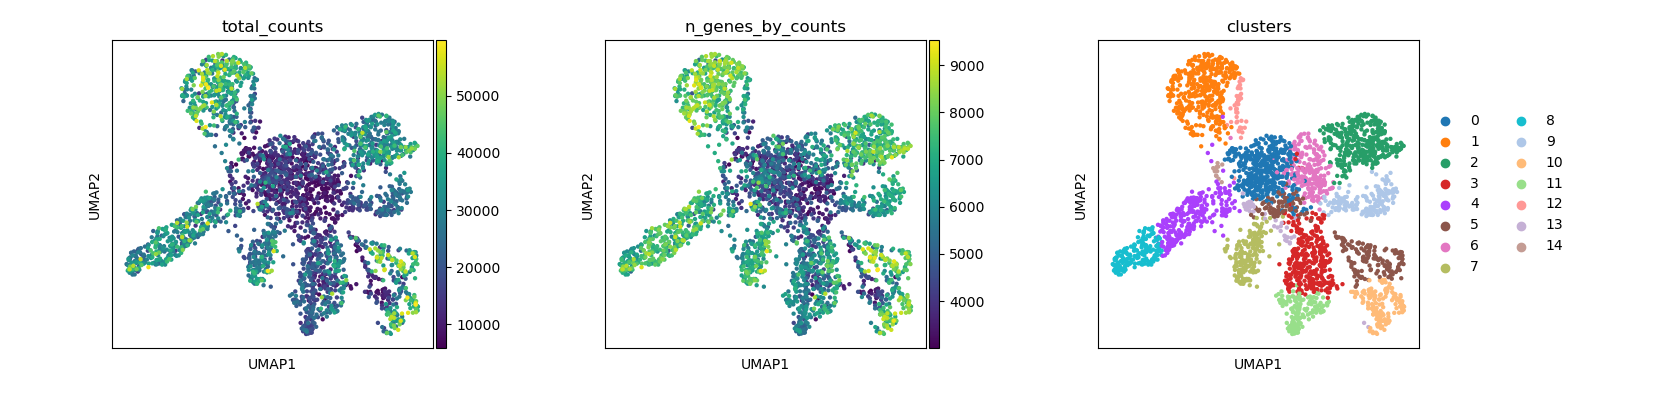

/Users/nataliecharitakis/opt/anaconda3/envs/squidpy/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


In [19]:
#Do some umap visualisations
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(ff_human_breast_cancer, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

<IPython.core.display.Javascript object>


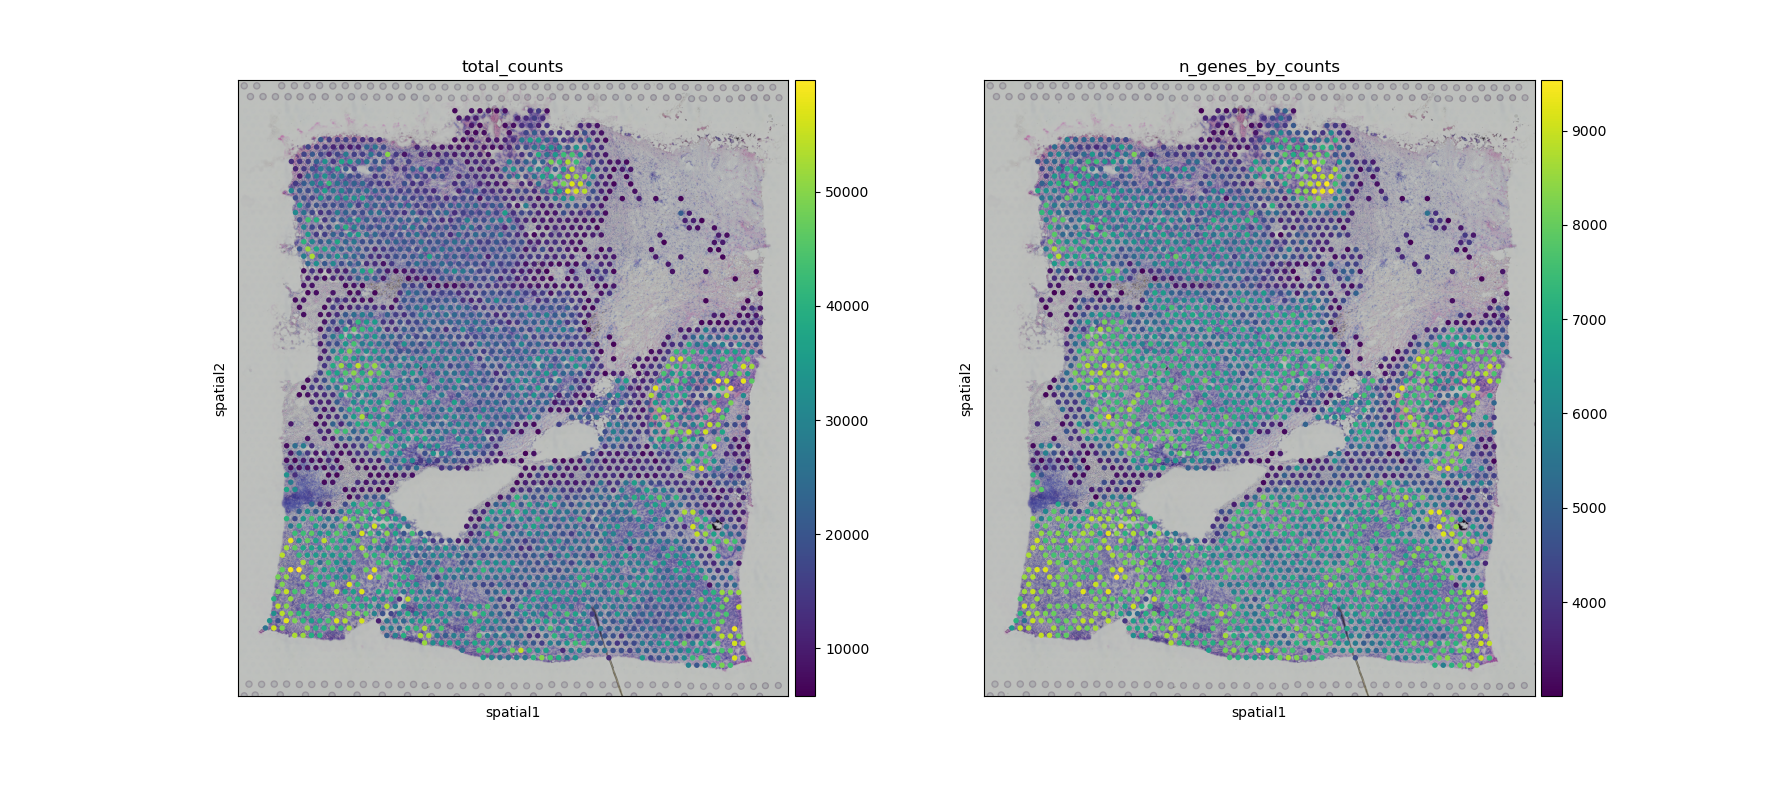

In [20]:
#Visualise in spatial coordinates
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(ff_human_breast_cancer, img_key="hires", color=["total_counts", "n_genes_by_counts"])

<IPython.core.display.Javascript object>


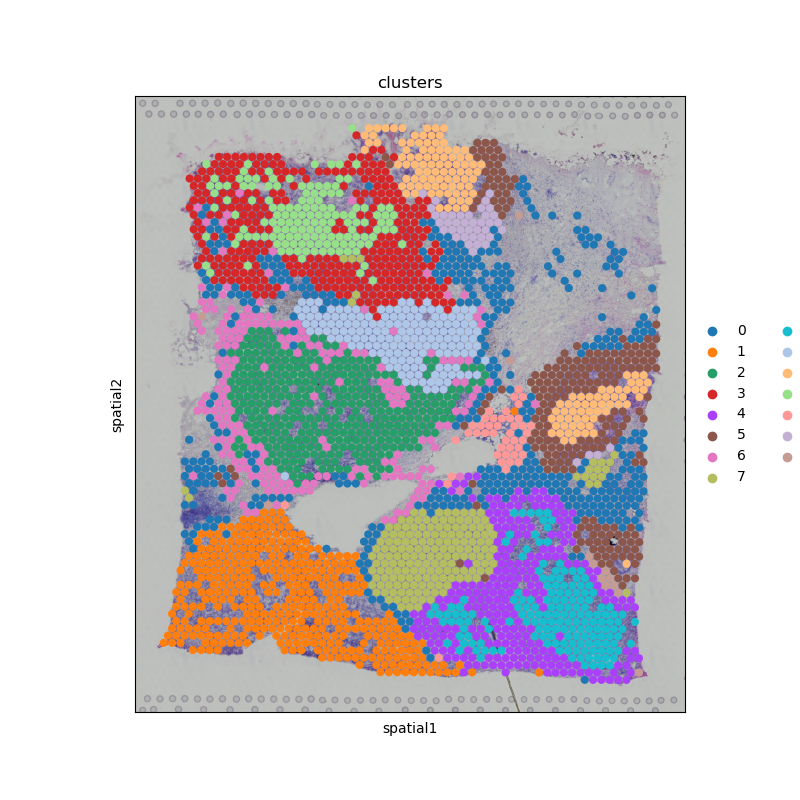

In [21]:
#Visualise cell type clusters by spatial organisation
sc.pl.spatial(ff_human_breast_cancer, img_key="hires", color="clusters", size=1.5)

categories: 0, 1, 2, etc.
var_group_labels: 5


<IPython.core.display.Javascript object>


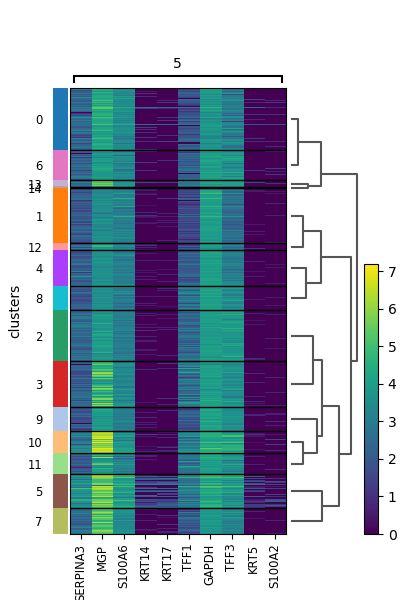

/Users/nataliecharitakis/opt/anaconda3/envs/squidpy/lib/python3.10/site-packages/scanpy/plotting/_anndata.py:2414: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  obs_tidy.index.value_counts(sort=False).iteritems()


In [22]:
#Compute marker genes across all clusters and plot heatmap of the top 10 markers in each cluster
sc.tl.rank_genes_groups(ff_human_breast_cancer, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(ff_human_breast_cancer, groups="5", n_genes=10, groupby="clusters")

### Write out necessary files

In [ ]:
##write this AnnData object to a didfferent file format
ff_human_breast_cancer.write_h5ad(filename='ff_breast_cancer.h5ad', compression=None, compression_opts=None, force_dense=None, as_dense=())

In [ ]:
#Write out normalised dataframe with expression values to file so it can be read back in for this purpose
ff_human_breast_cancer.write_csvs('preprocessed_output/',skip_data=False)

### Perform SVG ansysis with SpatialDE

In [25]:
%%time
#Now try and find SVGs with SpatialDE
#We need to convert normalised counts into a DF for spatial DE

counts = pd.DataFrame(ff_human_breast_cancer.X.todense(), columns=ff_human_breast_cancer.var_names, index=ff_human_breast_cancer.obs_names)
coord = pd.DataFrame(ff_human_breast_cancer.obsm['spatial'], columns=['x_coord', 'y_coord'], index=ff_human_breast_cancer.obs_names)
results = SpatialDE.run(coord, counts)

,I,pval_norm,var_norm,pval_norm_fdr_bh
MGP,0.879342,0.0,0.000111,0.0
COX6C,0.852083,0.0,0.000111,0.0
HLA-B,0.782431,0.0,0.000111,0.0
KRT8,0.776855,0.0,0.000111,0.0
IGFBP5,0.765432,0.0,0.000111,0.0
CPB1,0.760130,0.0,0.000111,0.0
CD74,0.754250,0.0,0.000111,0.0
CRISP3,0.738289,0.0,0.000111,0.0
IFI27,0.736983,0.0,0.000111,0.0
HLA-A,0.732046,0.0,0.000111,0.0


In [ ]:
#Sort results for all qvals >= 0.05 and add them to file
results_filtered = results[results["qval"] <= 0.05]
results_filtered = results_filtered.sort_values(by="qval")
results_filtered.to_csv('ff_breast_cancer_svgs_spatialde.csv')